# Similarity metrics for segmentation quality

## Allignment

In [13]:
import nibabel as nb
from pathlib import Path
import numpy as np
import glob, os

reg_dir = '/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/non_labeled_dataset_nifti_reg_2/'
dl_dir = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_0/test_orig_reg-cropped_non-labeled/'
output_path = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_0/test_orig_reg-cropped_non-labeled_allign/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

i=0
for folder1 in sorted(os.listdir(reg_dir)):

    # Name subject
    name_subject = folder1
    print(f'subject: {name_subject}')

    # Load t1_aux (to allign the other)
    t1_aux = nb.load(f'{reg_dir}{folder1}/labels.nii.gz')

    # Load t1 image (not alligned)
    t1 = nb.load(f'{dl_dir}{folder1}_cropped_seg_res.nii.gz')

    # Copy affine from t1_aux to t1
    nii = nb.Nifti1Image(t1.dataobj, t1_aux.affine, t1.header)
    nii.to_filename(f'{output_path}{name_subject}_cropped_seg_res_allign.nii.gz')
    
    # Dealing with files in that folder
    # for f in glob.glob(base_dir+folder1+'/input/'+folder1+'_T1_oriented_hdr.nii.gz'):
    #     os.remove(f)

    i+=1
    # if (i==1):
    #     break

subject: 2022160100001
subject: 2022160100002
subject: 2022160100003
subject: 2022160100011
subject: 2022160100012
subject: 2022160100014
subject: 2022160100015
subject: 2022160100016
subject: 2022160100017
subject: 2022160100020
subject: 2022160100026
subject: 2022160100030
subject: 2022160100031
subject: 2022160100032
subject: 2022160100033
subject: 2022160100036
subject: 2022160100039
subject: 2022160100043
subject: 2022160100044
subject: 2022160100046
subject: 2022160100047
subject: 2022160100052
subject: 2022160100059
subject: 2022160100064
subject: 2022160100071
subject: 2022160100072
subject: 2022160100081
subject: 2022160100083
subject: 2022160100085
subject: 2022160100091
subject: 2022160100105
subject: 2022160100106
subject: 2022160100109
subject: 2022160100112
subject: 2022160100116
subject: 2022160100117
subject: 2022160100120
subject: 2022160100126
subject: 2022160100127
subject: 2022160100132
subject: 2022160100133
subject: 2022160100135
subject: 2022160100136
subject: 20

## Compute metrics

In [19]:
import SimpleITK as sitk
import numpy as np
import pandas as pd
import os
import nibabel as nb

# nDSC (normalized DSC)
def dice_norm_metric(ground_truth, predictions):
    '''
    For a single example returns DSC_norm, fpr, fnr
    '''

    # Reference for normalized DSC
    r = 0.001 # It should be 1/N*(np.sum(voxels_label[i])/np.sum(voxels_image[i])) i belonging to training set
    # Cast to float32 type
    gt = ground_truth.astype("float32")
    seg = predictions.astype("float32")
    im_sum = np.sum(seg) + np.sum(gt)
    if im_sum == 0:
        return 1.0, 1.0, 1.0
    else:
        if np.sum(gt) == 0:
            k = 1.0
        else:
            k = (1 - r) * np.sum(gt) / (r * (len(gt.flatten()) - np.sum(gt)))
        tp = np.sum(seg[gt == 1])
        fp = np.sum(seg[gt == 0])
        fn = np.sum(gt[seg == 0])
        fp_scaled = k * fp
        dsc_norm = 2 * tp / (fp_scaled + 2 * tp + fn)

        fpr = fp / (len(gt.flatten()) - np.sum(gt))
        if np.sum(gt) == 0:
            fnr = 1.0
        else:
            fnr = fn / np.sum(gt)
        return dsc_norm # fpr, fnr

# Paths - segmentation results
reg_dir = '/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/non_labeled_dataset_nifti_reg_2/'
dl_dir = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_0/test_orig_reg-cropped_non-labeled_allign/'

# List of volumes for each individual label and subject
len_path = len([elem for elem in os.listdir(reg_dir)]) # elements in gt path = number of subjects
name_subject = [None]*len_path

# Save values in an array
# All labels
val_dsc             = np.zeros(len_path)
# val_hau = np.zeros(len(rest_subjects))
val_hau_avg         = np.zeros(len_path)
val_vol             = np.zeros(len_path)
val_ndsc            = np.zeros(len_path)
# Lens
val_dsc_lens        = np.zeros(len_path)
val_hau_avg_lens    = np.zeros(len_path)
val_vol_lens        = np.zeros(len_path)
val_ndsc_lens       = np.zeros(len_path)
# Globe
val_dsc_globe       = np.zeros(len_path)
val_hau_avg_globe   = np.zeros(len_path)
val_vol_globe       = np.zeros(len_path)
val_ndsc_globe      = np.zeros(len_path)
# Optic nerve  
val_dsc_nerve       = np.zeros(len_path)
val_hau_avg_nerve   = np.zeros(len_path)
val_vol_nerve       = np.zeros(len_path)
val_ndsc_nerve      = np.zeros(len_path)
# Intraconal fat
val_dsc_int_fat     = np.zeros(len_path)
val_hau_avg_int_fat = np.zeros(len_path)
val_vol_int_fat     = np.zeros(len_path)
val_ndsc_int_fat    = np.zeros(len_path)
# Extraconal fat
val_dsc_ext_fat     = np.zeros(len_path)
val_hau_avg_ext_fat = np.zeros(len_path)
val_vol_ext_fat     = np.zeros(len_path)
val_ndsc_ext_fat    = np.zeros(len_path)
# Lateral rectus muscle
val_dsc_lat_mus     = np.zeros(len_path)
val_hau_avg_lat_mus = np.zeros(len_path)
val_vol_lat_mus     = np.zeros(len_path)
val_ndsc_lat_mus    = np.zeros(len_path)
# Medial rectus musclenp.zeros(len_path)
val_dsc_med_mus     = np.zeros(len_path)
val_hau_avg_med_mus = np.zeros(len_path)
val_vol_med_mus     = np.zeros(len_path)
val_ndsc_med_mus    = np.zeros(len_path)
# Inferior rectus muscle
val_dsc_inf_mus     = np.zeros(len_path)
val_hau_avg_inf_mus = np.zeros(len_path)
val_vol_inf_mus     = np.zeros(len_path)
val_ndsc_inf_mus    = np.zeros(len_path)
# Superior rectus muscnp.zeros(len_path)
val_dsc_sup_mus     = np.zeros(len_path)
val_hau_avg_sup_mus = np.zeros(len_path)
val_vol_sup_mus     = np.zeros(len_path)
val_ndsc_sup_mus    = np.zeros(len_path)
    
reader = sitk.ImageFileReader()

i=0
for folder1 in sorted(os.listdir(reg_dir)):

    # Name subject
    name_subject[i] = str(folder1)
    print(f'subject: {name_subject[i]}')
    
    # ATLAS-based registration results
    reg_lab_path = f'{reg_dir}{folder1}/labels.nii.gz'
    reader.SetFileName(reg_lab_path)
    reg_lab_sitk = sitk.Cast(reader.Execute(), sitk.sitkUInt8)
    reg_lab_arr = sitk.GetArrayFromImage(reg_lab_sitk)

    # Deep Learning results
    dl_lab_path = f'{dl_dir}{folder1}_cropped_seg_res_allign.nii.gz'
    reader.SetFileName(dl_lab_path)
    dl_lab_sitk = sitk.Cast(reader.Execute(), sitk.sitkUInt8)
    dl_lab_arr = sitk.GetArrayFromImage(dl_lab_sitk)
    
    # Image size
    im_lab_size = reg_lab_arr.shape[0]*reg_lab_arr.shape[1]*reg_lab_arr.shape[2]

    # LENS
    # Measures Image Filter 
    overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
    overlap_measures_filter.Execute(reg_lab_sitk==1, dl_lab_sitk==1)
    # DSC
    dsc = overlap_measures_filter.GetDiceCoefficient() # Get the mean overlap (Dice coefficient) over all labels
    val_dsc_lens[i] = dsc
    # Volume
    vol = overlap_measures_filter.GetVolumeSimilarity() # Get the volume similarity over all labels
    val_vol_lens[i] = vol
    # Hausdorff distance
    if np.count_nonzero(reg_lab_arr==1)==0 or np.count_nonzero(dl_lab_arr==1)==0: val_hau_avg_lens[i] = 100
    else :
        hausdorf = sitk.HausdorffDistanceImageFilter()
        hausdorf.Execute(reg_lab_sitk==1, dl_lab_sitk==1)
        hausdorf_distance_avg = hausdorf.GetAverageHausdorffDistance() # Return the computed Hausdorff distance
        val_hau_avg_lens[i] = hausdorf_distance_avg
    # nDSC
    nDSC = dice_norm_metric(reg_lab_arr==1, dl_lab_arr==1)
    val_ndsc_lens[i] = nDSC
    
    # GLOBE EX LENS
    # Measures Image Filter 
    overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
    overlap_measures_filter.Execute(reg_lab_sitk==2, dl_lab_sitk==2)
    # DSC
    dsc = overlap_measures_filter.GetDiceCoefficient() # Get the mean overlap (Dice coefficient) over all labels
    val_dsc_globe[i] = dsc
    # Volume
    vol = overlap_measures_filter.GetVolumeSimilarity() # Get the volume similarity over all labels
    val_vol_globe[i] = vol
    # Hausdorff distance
    hausdorf = sitk.HausdorffDistanceImageFilter()
    hausdorf.Execute(reg_lab_sitk==2, dl_lab_sitk==2)
    hausdorf_distance_avg = hausdorf.GetAverageHausdorffDistance() # Return the computed Hausdorff distance
    val_hau_avg_globe[i] = hausdorf_distance_avg
    # nDSC
    nDSC = dice_norm_metric(reg_lab_arr==2, dl_lab_arr==2)
    val_ndsc_globe[i] = nDSC

    # OPTIC NERVE
    # Measures Image Filter 
    overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
    overlap_measures_filter.Execute(reg_lab_sitk==3, dl_lab_sitk==3)
    # DSC
    dsc = overlap_measures_filter.GetDiceCoefficient() # Get the mean overlap (Dice coefficient) over all labels
    val_dsc_nerve[i] = dsc
    # Volume
    vol = overlap_measures_filter.GetVolumeSimilarity() # Get the volume similarity over all labels
    val_vol_nerve[i] = vol
    # Hausdorff distance
    hausdorf = sitk.HausdorffDistanceImageFilter()
    hausdorf.Execute(reg_lab_sitk==3, dl_lab_sitk==3)
    hausdorf_distance_avg = hausdorf.GetAverageHausdorffDistance() # Return the computed Hausdorff distance
    val_hau_avg_nerve[i] = hausdorf_distance_avg
    # nDSC
    nDSC = dice_norm_metric(reg_lab_arr==3, dl_lab_arr==3)
    val_ndsc_nerve[i] = nDSC

    # INTRACONAL FAT
    # Measures Image Filter 
    overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
    overlap_measures_filter.Execute(reg_lab_sitk==4, dl_lab_sitk==4)
    # DSC
    dsc = overlap_measures_filter.GetDiceCoefficient() # Get the mean overlap (Dice coefficient) over all labels
    val_dsc_int_fat[i] = dsc
    # Volume
    vol = overlap_measures_filter.GetVolumeSimilarity() # Get the volume similarity over all labels
    val_vol_int_fat[i] = vol
    # Hausdorff distance
    hausdorf = sitk.HausdorffDistanceImageFilter()
    hausdorf.Execute(reg_lab_sitk==4, dl_lab_sitk==4)
    hausdorf_distance_avg = hausdorf.GetAverageHausdorffDistance() # Return the computed Hausdorff distance
    val_hau_avg_int_fat[i] = hausdorf_distance_avg
    # nDSC
    nDSC = dice_norm_metric(reg_lab_arr==4, dl_lab_arr==4)
    val_ndsc_int_fat[i] = nDSC

    # EXTRACONAL FAT
    # Measures Image Filter 
    overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
    overlap_measures_filter.Execute(reg_lab_sitk==5, dl_lab_sitk==5)
    # DSC
    dsc = overlap_measures_filter.GetDiceCoefficient() # Get the mean overlap (Dice coefficient) over all labels
    val_dsc_ext_fat[i] = dsc
    # Volume
    vol = overlap_measures_filter.GetVolumeSimilarity() # Get the volume similarity over all labels
    val_vol_ext_fat[i] = vol
    # Hausdorff distance
    hausdorf = sitk.HausdorffDistanceImageFilter()
    hausdorf.Execute(reg_lab_sitk==5, dl_lab_sitk==5)
    hausdorf_distance_avg = hausdorf.GetAverageHausdorffDistance() # Return the computed Hausdorff distance
    val_hau_avg_ext_fat[i] = hausdorf_distance_avg
    # nDSC
    nDSC = dice_norm_metric(reg_lab_arr==5, dl_lab_arr==5)
    val_ndsc_ext_fat[i] = nDSC

    # LATERAL RECTUS MUSCLE
    # Measures Image Filter 
    overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
    overlap_measures_filter.Execute(reg_lab_sitk==6, dl_lab_sitk==6)
    # DSC
    dsc = overlap_measures_filter.GetDiceCoefficient() # Get the mean overlap (Dice coefficient) over all labels
    val_dsc_lat_mus[i] = dsc
    # Volume
    vol = overlap_measures_filter.GetVolumeSimilarity() # Get the volume similarity over all labels
    val_vol_lat_mus[i] = vol
    # Hausdorff distance
    hausdorf = sitk.HausdorffDistanceImageFilter()
    hausdorf.Execute(reg_lab_sitk==6, dl_lab_sitk==6)
    hausdorf_distance_avg = hausdorf.GetAverageHausdorffDistance() # Return the computed Hausdorff distance
    val_hau_avg_lat_mus[i] = hausdorf_distance_avg
    # nDSC
    nDSC = dice_norm_metric(reg_lab_arr==6, dl_lab_arr==6)
    val_ndsc_lat_mus[i] = nDSC

    # MEDIAL RECTUS MUSCLE
    # Measures Image Filter 
    overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
    overlap_measures_filter.Execute(reg_lab_sitk==7, dl_lab_sitk==7)
    # DSC
    dsc = overlap_measures_filter.GetDiceCoefficient() # Get the mean overlap (Dice coefficient) over all labels
    val_dsc_med_mus[i] = dsc
    # Volume
    vol = overlap_measures_filter.GetVolumeSimilarity() # Get the volume similarity over all labels
    val_vol_med_mus[i] = vol
    # Hausdorff distance
    if np.count_nonzero(reg_lab_arr==7)==0 or np.count_nonzero(dl_lab_arr==7)==0: val_hau_avg_lens[i] = 100
    else :
        hausdorf = sitk.HausdorffDistanceImageFilter()
        hausdorf.Execute(reg_lab_sitk==7, dl_lab_sitk==7)
        hausdorf_distance_avg = hausdorf.GetAverageHausdorffDistance() # Return the computed Hausdorff distance
        val_hau_avg_med_mus[i] = hausdorf_distance_avg
    # nDSC
    nDSC = dice_norm_metric(reg_lab_arr==7, dl_lab_arr==7)
    val_ndsc_med_mus[i] = nDSC

    # INFERIOR RECTUS MUSCLE
    # Measures Image Filter 
    overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
    overlap_measures_filter.Execute(reg_lab_sitk==8, dl_lab_sitk==8)
    # DSC
    dsc = overlap_measures_filter.GetDiceCoefficient() # Get the mean overlap (Dice coefficient) over all labels
    val_dsc_inf_mus[i] = dsc
    # Volume
    vol = overlap_measures_filter.GetVolumeSimilarity() # Get the volume similarity over all labels
    val_vol_inf_mus[i] = vol
    # Hausdorff distance
    if np.count_nonzero(reg_lab_arr==8)==0 or np.count_nonzero(dl_lab_arr==8)==0: val_hau_avg_lens[i] = 100
    else :
        hausdorf = sitk.HausdorffDistanceImageFilter()
        hausdorf.Execute(reg_lab_sitk==8, dl_lab_sitk==8)
        hausdorf_distance_avg = hausdorf.GetAverageHausdorffDistance() # Return the computed Hausdorff distance
        val_hau_avg_inf_mus[i] = hausdorf_distance_avg
    # nDSC
    nDSC = dice_norm_metric(reg_lab_arr==8, dl_lab_arr==8)
    val_ndsc_inf_mus[i] = nDSC

    # SUPERIOR RECTUS MUSCLE
    # Measures Image Filter 
    overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
    overlap_measures_filter.Execute(reg_lab_sitk==9, dl_lab_sitk==9)
    # DSC
    dsc = overlap_measures_filter.GetDiceCoefficient() # Get the mean overlap (Dice coefficient) over all labels
    val_dsc_sup_mus[i] = dsc
    # Volume
    vol = overlap_measures_filter.GetVolumeSimilarity() # Get the volume similarity over all labels
    val_vol_sup_mus[i] = vol
    # Hausdorff distance
    hausdorf = sitk.HausdorffDistanceImageFilter()
    hausdorf.Execute(reg_lab_sitk==9, dl_lab_sitk==9)
    hausdorf_distance_avg = hausdorf.GetAverageHausdorffDistance() # Return the computed Hausdorff distance
    val_hau_avg_sup_mus[i] = hausdorf_distance_avg
    # nDSCvol
    nDSC = dice_norm_metric(reg_lab_arr==9, dl_lab_arr==9)
    val_ndsc_sup_mus[i] = nDSC

    # ALL LABELS
    # DSC
    dsc = (val_dsc_lens[i]+val_dsc_globe[i]+val_dsc_nerve[i]+val_dsc_int_fat[i]+val_dsc_ext_fat[i]+val_dsc_lat_mus[i]+val_dsc_med_mus[i]+val_dsc_inf_mus[i]+val_dsc_sup_mus[i])/9
    val_dsc[i] = dsc
    # Volume
    vol = (val_vol_lens[i]+val_vol_globe[i]+val_vol_nerve[i]+val_vol_int_fat[i]+val_vol_ext_fat[i]+val_vol_lat_mus[i]+val_vol_med_mus[i]+val_vol_inf_mus[i]+val_vol_sup_mus[i])/9
    val_vol[i] = vol
    # Hausdorff distance
    hau_avg = (val_hau_avg_lens[i]+val_hau_avg_globe[i]+val_hau_avg_nerve[i]+val_hau_avg_int_fat[i]+val_hau_avg_ext_fat[i]+val_hau_avg_lat_mus[i]+val_hau_avg_med_mus[i]+val_hau_avg_inf_mus[i]+val_hau_avg_sup_mus[i])/9
    val_hau_avg[i] = hau_avg
    # nDSC
    nDSC = (val_ndsc_lens[i]+val_ndsc_globe[i]+val_ndsc_nerve[i]+val_ndsc_int_fat[i]+val_ndsc_ext_fat[i]+val_ndsc_lat_mus[i]+val_ndsc_med_mus[i]+val_ndsc_inf_mus[i]+val_ndsc_sup_mus[i])/9
    val_ndsc[i] = nDSC

    i+=1
    # if i==2:
    #     break

subject: 2022160100001
subject: 2022160100002
subject: 2022160100003
subject: 2022160100011
subject: 2022160100012
subject: 2022160100014
subject: 2022160100015
subject: 2022160100016
subject: 2022160100017
subject: 2022160100020
subject: 2022160100026
subject: 2022160100030
subject: 2022160100031
subject: 2022160100032
subject: 2022160100033
subject: 2022160100036
subject: 2022160100039
subject: 2022160100043
subject: 2022160100044
subject: 2022160100046
subject: 2022160100047
subject: 2022160100052
subject: 2022160100059
subject: 2022160100064
subject: 2022160100071
subject: 2022160100072
subject: 2022160100081
subject: 2022160100083
subject: 2022160100085
subject: 2022160100091
subject: 2022160100105
subject: 2022160100106
subject: 2022160100109
subject: 2022160100112
subject: 2022160100116
subject: 2022160100117
subject: 2022160100120
subject: 2022160100126
subject: 2022160100127
subject: 2022160100132
subject: 2022160100133
subject: 2022160100135
subject: 2022160100136
subject: 20

## Save values to .csv

In [20]:
import csv

metrics = [
    'Subject',  'DSC_all',     'Haus_avg_all',     'Volume_all',     'nDSC_all', 
                'DSC_lens',    'Haus_avg_lens',    'Volume_lens',    'nDSC_lens',  
                'DSC_globe',   'Haus_avg_globe',   'Volume_globe',   'nDSC_globe', 
                'DSC_nerve',   'Haus_avg_nerve',   'Volume_nerve',   'nDSC_nerve', 
                'DSC_int_fat', 'Haus_avg_int_fat', 'Volume_int_fat', 'nDSC_int_fat',
                'DSC_ext_fat', 'Haus_avg_ext_fat', 'Volume_ext_fat', 'nDSC_ext_fat',
                'DSC_lat_mus', 'Haus_avg_lat_mus', 'Volume_lat_mus', 'nDSC_lat_mus',
                'DSC_med_mus', 'Haus_avg_med_mus', 'Volume_med_mus', 'nDSC_med_mus',
                'DSC_inf_mus', 'Haus_avg_inf_mus', 'Volume_inf_mus', 'nDSC_inf_mus',
                'DSC_sup_mus', 'Haus_avg_sup_mus', 'Volume_sup_mus', 'nDSC_sup_mus'
]

vals = np.array([
    name_subject,   val_dsc,         val_hau_avg,         val_vol,         val_ndsc,        
                    val_dsc_lens,    val_hau_avg_lens,    val_vol_lens,    val_ndsc_lens,   
                    val_dsc_globe,   val_hau_avg_globe,   val_vol_globe,   val_ndsc_globe,  
                    val_dsc_nerve,   val_hau_avg_nerve,   val_vol_nerve,   val_ndsc_nerve,  
                    val_dsc_int_fat, val_hau_avg_int_fat, val_vol_int_fat, val_ndsc_int_fat,
                    val_dsc_ext_fat, val_hau_avg_ext_fat, val_vol_ext_fat, val_ndsc_ext_fat,
                    val_dsc_lat_mus, val_hau_avg_lat_mus, val_vol_lat_mus, val_ndsc_lat_mus,
                    val_dsc_med_mus, val_hau_avg_med_mus, val_vol_med_mus, val_ndsc_med_mus,
                    val_dsc_inf_mus, val_hau_avg_inf_mus, val_vol_inf_mus, val_ndsc_inf_mus,
                    val_dsc_sup_mus, val_hau_avg_sup_mus, val_vol_sup_mus, val_ndsc_sup_mus,
])

vals = vals.T

with open('/mnt/sda1/Repos/a-eye/Output/sim_reg_vs_dl.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(metrics)
    writer.writerows(vals)

## Read values from .csv

lens 0.7
globe 0.66
nerve 0.9
intraconal fat 0.71
extraconal fat 0.67
lateral rectus muscle 0.55
medial rectus muscle 0.69
inferior rectus muscle 0.76
superior rectus muscle 0.75


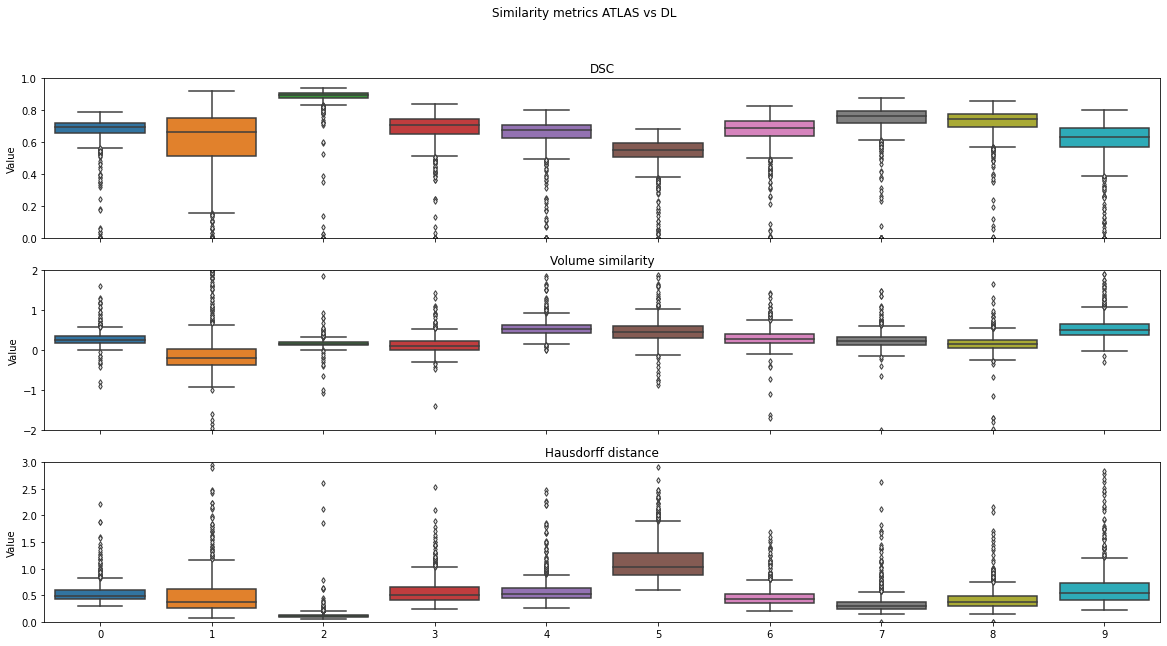

In [3]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import Line2D
import numpy as np

csv_file = pd.read_csv('/mnt/sda1/Repos/a-eye/Output/sim_reg_vs_dl.csv')

# Dataframes {DSC, nDSC, Volume (voxels)} separate labels for N=5 only
data_dsc = [csv_file['DSC_all'], csv_file['DSC_lens'], csv_file['DSC_globe'], csv_file['DSC_nerve'], csv_file['DSC_int_fat'], csv_file['DSC_ext_fat'], csv_file['DSC_lat_mus'], csv_file['DSC_med_mus'], csv_file['DSC_inf_mus'], csv_file['DSC_sup_mus']]
data_ndsc = [csv_file['nDSC_all'],  csv_file['nDSC_lens'], csv_file['nDSC_globe'], csv_file['nDSC_nerve'], csv_file['nDSC_int_fat'], csv_file['nDSC_ext_fat'], csv_file['nDSC_lat_mus'], csv_file['nDSC_med_mus'], csv_file['nDSC_inf_mus'], csv_file['nDSC_sup_mus']]
data_vol = [csv_file['Volume_all'], csv_file['Volume_lens'], csv_file['Volume_globe'], csv_file['Volume_nerve'], csv_file['Volume_int_fat'], csv_file['Volume_ext_fat'], csv_file['Volume_lat_mus'], csv_file['Volume_med_mus'], csv_file['Volume_inf_mus'], csv_file['Volume_sup_mus']]
data_haus = [csv_file['Haus_avg_all'], csv_file['Haus_avg_lens'], csv_file['Haus_avg_globe'], csv_file['Haus_avg_nerve'], csv_file['Haus_avg_int_fat'], csv_file['Haus_avg_ext_fat'], csv_file['Haus_avg_lat_mus'], csv_file['Haus_avg_med_mus'], csv_file['Haus_avg_inf_mus'], csv_file['Haus_avg_sup_mus']]

labels = ['lens', 'globe', 'nerve', 'intraconal fat', 'extraconal fat', 'lateral rectus muscle', 'medial rectus muscle', 'inferior rectus muscle', 'superior rectus muscle']
median = [np.around(np.median(x), 2) for x in data_dsc]
for i in range(len(labels)):
    print(labels[i], median[i])

# Figure
fig, axs = plt.subplots(3, figsize=(20,10), sharex=True)
fig.canvas.manager.set_window_title('Similarity metrics ATLAS vs DL')
fig.suptitle('Similarity metrics ATLAS vs DL')

# Set labels and titles
axs[0].set_title('DSC')
axs[0].set_ylim([0, 1])
axs[1].set_title('Volume similarity')
axs[1].set_ylim([-2, 2])
axs[2].set_title('Hausdorff distance')
axs[2].set_ylim([0, 3])

# Outliers
flierprops = dict(markerfacecolor='0.9', markersize=4, linestyle='none')

# Boxplot & Swarmplot (points)
axs[0] = sns.boxplot(data=data_dsc, ax=axs[0], flierprops=flierprops).set(ylabel="Value")
axs[1] = sns.boxplot(data=data_vol, ax=axs[1], flierprops=flierprops).set(ylabel="Value")
axs[2] = sns.boxplot(data=data_haus, ax=axs[2], flierprops=flierprops).set(ylabel="Value")
# axs[0].set_xticks(['all','lens','globe','nerve','int_fat','ext_fat','lat_mus','med_mus','inf_mus','sup_mus'])

# Save figure
plt.savefig('/mnt/sda1/Repos/a-eye/Output/reg_vs_dl.png', bbox_inches='tight')

plt.show()
